In [1]:
#@title **Imports**
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import product as cartesian_prod

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Variable parameters**

In [2]:
num_train_data=3000
num_vali_data=3000
num_test_data=3000
dim=2
num_modes=2*dim





model_type = "Regression" #"Classification" #for four mode classification data use Classification and for square decision tree data use Regression
seed=0
num_hidden_layers=3
input_dim=dim
output_dim=1
num_hidden_nodes=[5,5,5]
beta=[20,10000] #When freeze is true then the layer corr to unfreeze node beta value is 20 rest 10k, for freeze false every layer beta is 20.
no_of_batches=1 #[1,10,100]
modep='pwc' #piece wise constant means all 1's will be given as input to NPV.
num_epoch=100000
lr=0.00005
weight_decay=0.0



test_on_train_data = False #Default False, set True when generate node hyperplanes on training data




freeze = False #True - when freeze weights of all nodes except one. False- when all nodes weights are varying
layer_num = 3 #Layer number whose node is only varying and rest are freezed
node_num = 3 #Node number of the above layer which is only varying rest are freeze





NPF_freeze = False #Default False, set True - when freeze the whole NPF
NPV_freeze = False #Default False, set True - when freeze the whole NPV
NPF_pretrained_freezed = True #Default False, set True - when freeze the whole NPF after training it to max and NPV is trained from reinit
NPV_pretrained_freezed = False #Default False, set True - when freeze the whole NPV after training it to max and NPF is trained from reinit


train_model = False #Set to true if training a model and False if only infer a trained model
infer_model = True #Set to true if infer a pretrained model or infer after training



print_all_paths = False #Set to true if wants to print all the path values of init,mid,last epoch
show_all_epoch_node_hyperplane = False #Set to true if wants to show and store all node hyperplanes of all epochs
best_epoch_show = False #Set to true if wants to show the node hyperplanes of the best epoch
save_img = False

file_path = "/content/drive/MyDrive/Research/Saved_models/"
file_name_load = file_path+"R_NPF_pretrained_Fixed_1L_3L5N_Beta_20_seed_365.npz" #change the model name to infer a pretrained model



enter_path = (0,1,2) #enter the path whose path_value is to be determined in list form as (1st_layer_node_num,2nd_layer_node_num,3rd_layer_node_num)
enter_epoch = 0 #enter the epch no (perfect sq number) whose node hyperplane is to be visualised
plot_epoch = 5000 #epoch till which want to plot


max_no_of_nodes=max(num_hidden_nodes)

In [3]:
#@title **Synthetic data**
def set_npseed(seed):
  np.random.seed(seed)
  random.seed(seed)

def set_torchseed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  
#Four mode classification data
def data_gen1(num_train_data,num_vali_data,num_test_data,dim=2,seed=0):
  # np.random.seed(6790)
  set_npseed(seed = seed)
  d=dim
  num_modes=2*d
  centers = np.concatenate((np.eye(d), -1*np.eye(d)), axis=0)
  np.random.shuffle(centers)
  # np.random.seed(475)
  hard=num_modes//2

  a=[4]* hard + [1]*(num_modes - hard)
  mode_frac = np.array([1./num_modes]*num_modes)
  b=1.
  num_train_data = num_train_data 
  num_vali_data=num_vali_data
  num_test_data=num_test_data
  num_data = num_train_data + num_vali_data + num_test_data

  num_data_per_mode = np.int32(num_data*mode_frac)
  num_data_per_mode = np.concatenate((num_data_per_mode,[np.sum(num_data_per_mode)]))

  landmarks=[-1]*num_modes
  labels=[-1]*num_modes
  for i in range(num_modes):
    landmarks[i] = 0.05*np.random.randn(a[i],d)
    landmarks[i]+=centers[i]
    labels[i] = (i - np.arange(len(landmarks[i])))%2
      
  data=[-1]*num_modes
  data_labels=[-1]*num_modes

  train_data=[-1]*num_modes
  train_data_labels=[-1]*num_modes

  test_data=[-1]*num_modes
  test_data_labels=[-1]*num_modes

  vali_data=[-1]*num_modes
  vali_data_labels=[-1]*num_modes


  modes_data=[]
  # np.random.seed(12345)

  for i in range(num_modes):
    data[i] = 0.1*np.random.randn(num_data_per_mode[i],d)
    data[i] += centers[i]
    data_labels[i] = np.zeros(num_data_per_mode[i])
    for j in range(len(data_labels[i])):
      dists = pairwise_distances(data[i][j:j+1,:],landmarks[i])                                   
      j_star = np.argmin(dists[0])
      data_labels[i][j]=labels[i][j_star]
      
      train_data[i] = np.array(data[i][:int(mode_frac[i]*num_train_data)])
      train_data_labels[i] = np.array(data_labels[i][:int(mode_frac[i]*num_train_data)])

      vali_data[i] = np.array(data[i][int(mode_frac[i]*num_train_data): \
                                      int(mode_frac[i]*num_train_data)+int(mode_frac[i]*num_vali_data)])
      vali_data_labels[i] = np.array(data_labels[i][int(mode_frac[i]*num_train_data): \
                                      int(mode_frac[i]*num_train_data)+int(mode_frac[i]*num_vali_data)])

      test_data[i] = np.array(data[i][-int(mode_frac[i]*num_test_data):])
      test_data_labels[i] = np.array(data_labels[i][-int(mode_frac[i]*num_test_data):])
      
  return data,data_labels,train_data,train_data_labels,test_data,test_data_labels,vali_data,vali_data_labels,landmarks,labels,centers,mode_frac

def uniform_data_gen(num_data,dim=2):
  n=num_data
  d=dim
  x0x1_min = [-1.0, -1.0]
  x0x1_max = [1.0, 1.0]
  data = np.random.uniform(low=x0x1_min, high=x0x1_max, size=(n,d))
  y=np.zeros(n,dtype=np.float32)
  for i,val in enumerate(data):
    if(-1<=val[0]<=0 and 0<=val[1]<=1):
      y[i]=1
    elif (0<=val[0]<=1 and 0.5<=val[1]<=1):
      y[i]=0.2
    elif(0<=val[0]<=1 and -0.5<=val[1]<=0.5):
      y[i]=0.5
    else:
      y[i]=-1
  return data,y

#Square decision tree data
def data_gen2(num_train_data,num_vali_data,num_test_data,dim=2,seed=0):
  set_npseed(seed = seed)
  train_data,train_data_labels=uniform_data_gen(num_train_data,dim=dim)
  vali_data,vali_data_labels=uniform_data_gen(num_vali_data,dim=dim)
  test_data,test_data_labels=uniform_data_gen(num_test_data,dim=dim)
  data = np.concatenate((train_data,vali_data),axis=0)
  data = np.concatenate((data,test_data),axis=0)
  data_labels = np.concatenate((train_data_labels,vali_data_labels),axis=0)
  data_labels = np.concatenate((data_labels,test_data_labels),axis=0)
  return data,data_labels,train_data,train_data_labels,test_data,test_data_labels,vali_data,vali_data_labels,None,None,None,None

In [4]:
#@title **DLGN_FC**
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class DLGN_FC(nn.Module):
  def __init__(self, to_copy=None,NPF_pretrained=True,NPV_pretrained=True, num_hidden_layers=0, input_dim=2, output_dim=1, num_hidden_nodes=[], beta=20, mode='pwc'):
    super(DLGN_FC, self).__init__()
    if to_copy==None:
      self.gating_layers=[]
      self.value_layers=[]
      self.num_hidden_layers = num_hidden_layers
      self.beta=beta  # Soft gating parameter
      self.mode = mode
      self.num_nodes=[input_dim]+num_hidden_nodes+[output_dim]
      for i in range(num_hidden_layers+1):
        self.gating_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1]))
        self.value_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1], bias=False))
    else:
      self.gating_layers=[]
      self.value_layers=[]
      self.num_hidden_layers = to_copy.num_hidden_layers
      self.beta=to_copy.beta  # Soft gating parameter
      self.mode = to_copy.mode
      self.num_nodes=list(to_copy.num_nodes)
      for i in range(self.num_hidden_layers+1):
        self.gating_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1]))
        self.value_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1], bias=False))
        if NPF_pretrained:
          self.gating_layers[i].weight.data =  torch.Tensor(np.array(to_copy.gating_layers[i].weight.detach().numpy()))
          self.gating_layers[i].bias.data = torch.Tensor(np.array(to_copy.gating_layers[i].bias.detach().numpy()))
        if NPV_pretrained:
          self.value_layers[i].weight.data = torch.Tensor(np.array(to_copy.value_layers[i].weight.detach().numpy()))

                

  def return_gating_functions(self):
    effective_weights = []
    effective_biases =[]
    for i in range(self.num_hidden_layers):
      curr_weight = self.gating_layers[i].weight
      curr_bias = self.gating_layers[i].bias
      if i==0:
        effective_weights.append(curr_weight)
        effective_biases.append(curr_bias)
      else:
        effective_biases.append(torch.matmul(curr_weight,effective_biases[-1])+curr_bias)
        effective_weights.append(torch.matmul(curr_weight,effective_weights[-1]))
    return effective_weights, effective_biases
    # effective_weights (and effective biases) is a list of size num_hidden_layers
              

  def forward(self, x):
    gate_scores=[x]
    if self.mode=='pwc':
      values=[torch.ones(x.shape)]
    else:
      values=[x]
    
    for i in range(self.num_hidden_layers):
      beta_used = beta[0]
      if ((i!=layer_num-1) and freeze):
        beta_used = beta[1]
      gate_scores.append(self.gating_layers[i](gate_scores[-1]))
      curr_gate_on_off = torch.sigmoid(beta_used*gate_scores[-1])
      values.append(self.value_layers[i](values[-1])*curr_gate_on_off)
    values.append(self.value_layers[self.num_hidden_layers](values[-1]))
    # Values is a list of size 1+num_hidden_layers+1
    #gate_scores is a list of size 1+num_hidden_layers
    return values,gate_scores

Using cpu device


In [5]:
#@title **Check perfect sq**
def perfectSq(N) :
	sq_root = round(N**(1/2));
	if sq_root * sq_root == N :
		return True;
	else :
		return False;

In [6]:
#@title **Train DLGN model**
if train_model:
  def train_dlgn(seed,num_hidden_layers,input_dim,output_dim,num_hidden_nodes,beta,no_of_batches,
                mode,layer_num,node_num,train_data_curr,vali_data_curr,test_data_curr,train_labels_curr,test_labels_curr,vali_labels_curr,num_epoch,freeze,DLGN_obj_pretrained=None,NPF_pretrained = True,NPV_pretrained = True):
    # torch.random.manual_seed(1222)
    # torch.random.manual_seed(2311)
    layer_num=layer_num-1
    node_num=node_num-1
    set_torchseed(seed)
    if freeze:
      DLGN_obj_initial = None
    DLGN_obj = None
    DLGN_obj_return = None
    if DLGN_obj_pretrained == None:
      DLGN_obj = DLGN_FC(num_hidden_layers=num_hidden_layers, input_dim=input_dim, output_dim=output_dim, 
                        num_hidden_nodes=num_hidden_nodes, beta=beta, mode=mode)
    else:
      DLGN_obj = DLGN_FC(to_copy=DLGN_obj_pretrained,NPF_pretrained=NPF_pretrained,NPV_pretrained=NPV_pretrained)

    if freeze:
      DLGN_obj_initial = DLGN_FC(to_copy=DLGN_obj)
    
    DLGN_obj_return = DLGN_FC(to_copy=DLGN_obj)

    if model_type == "Classification":
      criterion = nn.CrossEntropyLoss()
    if model_type == "Regression":
      criterion = nn.MSELoss()
    
    

    DLGN_params = []
    DLGN_params += [item.weight for item in DLGN_obj.gating_layers]
    DLGN_params += [item.bias for item in DLGN_obj.gating_layers]
    DLGN_params += [item.weight for item in DLGN_obj.value_layers]
  #     DLGN_params += [item.bias for item in DLGN_obj.value_layers]

    # print("H0")
    # print(DLGN_params)

    if NPF_freeze:
      for index,param in enumerate(DLGN_params):
        if(index<2*len(DLGN_obj.gating_layers)):
          param.requires_grad=False
    if NPV_freeze:
      for index,param in enumerate(DLGN_params):
        if(index>=2*len(DLGN_obj.gating_layers)):
          param.requires_grad=False
    if freeze:
      for index,param in enumerate(DLGN_params):
        if((index != layer_num)):
          param.requires_grad=False
        if((index==len(DLGN_obj.gating_layers)+layer_num)):
          param.requires_grad=True

    # print("H1")
    # print(DLGN_params)

    optimizer = optim.Adam(DLGN_params, lr=lr, weight_decay=weight_decay)
    

    # print("H2")
    # print(DLGN_params)
    
    train_data_torch = torch.Tensor(train_data_curr)
    vali_data_torch = torch.Tensor(vali_data_curr)
    test_data_torch = torch.Tensor(test_data_curr)

    if model_type == "Classification":
      train_labels_torch = torch.tensor(train_labels_curr, dtype=torch.int64)
      test_labels_torch = torch.tensor(test_labels_curr, dtype=torch.int64)
      vali_labels_torch = torch.tensor(vali_labels_curr, dtype=torch.int64)
    if model_type == "Regression":
      train_labels_torch = torch.tensor(train_labels_curr)
      test_labels_torch = torch.tensor(test_labels_curr)
      vali_labels_torch = torch.tensor(vali_labels_curr)

    num_batches = no_of_batches
    batch_size = len(train_data_curr)//num_batches
    losses=[]
    DLGN_obj_store = []
    best_vali_error = len(vali_labels_curr)

    # print("H3")
    # print(DLGN_params)

    for epoch in tqdm(range(num_epoch)):  # loop over the dataset multiple times
      running_loss = 0.0
      if perfectSq(epoch):
        DLGN_obj_store.append(DLGN_FC(to_copy=DLGN_obj))
      
      for batch_start in range(0,len(train_data_curr),batch_size):
        optimizer.zero_grad()
        values,gate_scores = DLGN_obj(train_data_torch[batch_start:batch_start+batch_size])
        
        if model_type == "Classification":
          outputs = torch.cat((-1*values[-1], values[-1]), dim=1)
          loss = criterion(outputs, train_labels_torch[batch_start:batch_start+batch_size])
        if model_type == "Regression":
          outputs = values[-1]
          loss = criterion(outputs, train_labels_torch[batch_start:batch_start+batch_size].reshape(outputs.shape))

        # print("H4")
        # print(DLGN_params)

        loss.backward()
        optimizer.step()

        # print("H5")
        # print(DLGN_params)
        if freeze:
          for node in range(num_hidden_nodes[layer_num]):
            if(node!=node_num):
              # self.gating_layers[i].weight.data =  torch.Tensor(np.array(to_copy.gating_layers[i].weight.detach().numpy()))
              DLGN_params[layer_num].data[node]= DLGN_obj_initial.gating_layers[layer_num].weight.data[node]
              DLGN_params[len(DLGN_obj.gating_layers)+layer_num].data[node]= DLGN_obj_initial.gating_layers[layer_num].bias.data[node]

        # print("H6")
        # print(DLGN_params)

        running_loss += loss.item()    
      losses.append(running_loss/num_batches)

      values,gate_scores =DLGN_obj(vali_data_torch)
      if model_type == "Classification":
        vali_preds = torch.cat((-1*values[-1], values[-1]), dim=1)
        vali_preds = torch.argmax(vali_preds, dim=1).numpy()
        vali_error= np.sum(vali_labels_torch.numpy()!=vali_preds)
      if model_type == "Regression":
        vali_preds = values[-1]
        vali_error = criterion(vali_preds, vali_labels_torch.reshape(vali_preds.shape)).item()
        vali_preds = vali_preds.detach().numpy()
      if vali_error < best_vali_error:
        DLGN_obj_return = DLGN_FC(to_copy=DLGN_obj)
        best_vali_error = vali_error
      
    values,gate_scores =DLGN_obj_return(test_data_torch)

    if model_type == "Classification":
      test_preds = torch.cat((-1*values[-1], values[-1]), dim=1)
      test_preds = torch.argmax(test_preds, dim=1).numpy()
      test_error= np.sum(test_labels_torch.numpy()!=test_preds)
    if model_type == "Regression":
      test_preds = values[-1]
      test_error = criterion(test_preds, test_labels_torch.reshape(test_preds.shape)).item()
      test_preds = test_preds.detach().numpy()
    values,gate_scores=DLGN_obj_return(train_data_torch)

    if model_type == "Classification":
      train_preds = torch.cat((-1*values[-1], values[-1]), dim=1)
      train_preds = torch.argmax(train_preds, dim=1).numpy()
      train_error= np.sum(train_labels_torch.numpy()!=train_preds)
    if model_type == "Regression":
      train_preds = values[-1]
      train_error = criterion(train_preds, train_labels_torch.reshape(train_preds.shape)).item()
      train_preds = train_preds.detach().numpy()

    plt.figure()
    plt.title("DLGN loss vs epoch")
    plt.plot(losses)
    return losses,test_error, train_error, test_preds, DLGN_obj_return, DLGN_obj_store

In [7]:
#@title **Generating data**
if model_type == "Classification":
  data_gen = data_gen1
if model_type == "Regression":
  data_gen = data_gen2
  
data,data_labels,train_data,train_data_labels,test_data,test_data_labels,vali_data,vali_data_labels, \
landmarks,labels,centers,mode_frac= data_gen(num_train_data,num_vali_data,num_test_data,dim=2,seed=0)

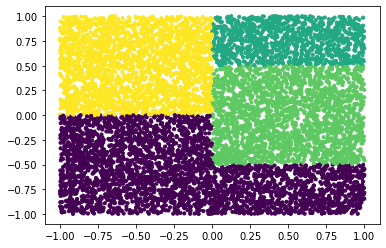

In [8]:
#@title **Plotting the data**
if model_type == "Classification":
  fig=plt.scatter(np.concatenate(data)[:,0], np.concatenate(data)[:,1], c=np.concatenate(data_labels), s=10)
if model_type == "Regression":
  fig=plt.scatter(data[:,0], data[:,1], c=data_labels, s=10)


In [9]:
#@title **Training a DLGN model**
## Convention 0th layer is input layer 1st layer is 1st hidden layer and last layer is output layer
## so 3 hidden layers mean 1 input node + 3 hidden layers + 1 output layer

if model_type == "Classification":
  train_data_curr = np.concatenate(train_data[0:num_modes])
  train_labels_curr = np.concatenate(train_data_labels[0:num_modes])
  vali_data_curr = np.concatenate(vali_data[0:num_modes])
  vali_labels_curr = np.concatenate(vali_data_labels[0:num_modes])
  test_data_curr = np.concatenate(test_data[0:num_modes])
  test_labels_curr = np.concatenate(test_data_labels[0:num_modes]) 

if model_type == "Regression":
  train_data_curr = train_data
  train_labels_curr = train_data_labels
  vali_data_curr = vali_data
  vali_labels_curr = vali_data_labels
  test_data_curr = test_data
  test_labels_curr = test_data_labels

# print("Num Train = ",len(train_data_curr))
# print("Num Vali  = ",len(vali_data_curr))
# print("Num Test  = ",len(test_data_curr))
# print("==========DLGN===========") 
if train_model:
  losses,test_error, train_error, predictions_dlgn, DLGN_obj_final, DLGN_obj_store = train_dlgn(seed,num_hidden_layers,input_dim,output_dim,num_hidden_nodes,beta,
                no_of_batches,modep,layer_num,node_num,train_data_curr,vali_data_curr,test_data_curr,train_labels_curr,test_labels_curr,vali_labels_curr,num_epoch,freeze)   

  #predictions_dlgn -- labels corresponding to the best validation model
  #DLGN_obj_final -- model corresponding to epoch with the best validation acc
  #DLGN_obj_store -- store models corresponding to epochs at regular intervals

  if NPF_pretrained_freezed:
    # seed=141334
    NPF_freeze = True
    losses,test_error, train_error, predictions_dlgn, DLGN_obj_final, DLGN_obj_store = train_dlgn(seed,num_hidden_layers,input_dim,output_dim,num_hidden_nodes,beta,
                no_of_batches,modep,layer_num,node_num,train_data_curr,vali_data_curr,test_data_curr,train_labels_curr,test_labels_curr,vali_labels_curr,num_epoch,freeze,DLGN_obj_pretrained=DLGN_obj_store[-1],NPF_pretrained = True,NPV_pretrained = False)   
    NPF_freeze = False
  if NPV_pretrained_freezed:
    NPV_freeze = True
    losses,test_error, train_error, predictions_dlgn, DLGN_obj_final, DLGN_obj_store = train_dlgn(seed,num_hidden_layers,input_dim,output_dim,num_hidden_nodes,beta,
                no_of_batches,modep,layer_num,node_num,train_data_curr,vali_data_curr,test_data_curr,train_labels_curr,test_labels_curr,vali_labels_curr,num_epoch,freeze,DLGN_obj_pretrained=DLGN_obj_store[-1],NPF_pretrained = False,NPV_pretrained = True)   
    NPV_freeze = False

In [10]:
#@title **Storing the trained output**
# import pickle
# with open("DLGN_obj_store.pickle", "wb") as fp:   #Pickling
#   pickle.dump(DLGN_obj_store, fp)
# with open("DLGN_obj_store.pickle", "rb") as fp:   # Unpickling
#   b = pickle.load(fp)
#File name
if train_model:
  Beta_str = "Beta_"+str(beta[0])+"_"
  if model_type == "Regression":
    a="R_"
  if model_type == "Classification":
    a="C_"
  if freeze:
    prefix = "Layer_"+str(layer_num)+"_node_"+str(node_num)+"_"
    Beta_str = "Beta_"+str(beta[0])+"_"+str(int(beta[1]/1000))+"k_"
  elif NPF_freeze:
    prefix = "NPF_Fixed_"
  elif NPV_freeze:
    prefix = "NPV_Fixed_"
  elif NPF_pretrained_freezed:
    prefix = "NPF_pretrained_Fixed_"
  elif NPV_pretrained_freezed:
    prefix = "NPV_pretrained_Fixed_"
  else:
    prefix = "No_node_"
  epoch_str = str(int(num_epoch/100000))+"L_"
  file_name = a+prefix+epoch_str+str(num_hidden_layers)+"L"+str(max_no_of_nodes)+"N_"+Beta_str+"seed_"+str(seed)
  # save numpy array as npz file
  from numpy import asarray
  from numpy import savez_compressed
  # save to npy file
  file_name=file_path+file_name
  savez_compressed(file_name, losses,test_error, train_error, predictions_dlgn, DLGN_obj_final, DLGN_obj_store)
  file_name_load = file_name+".npz"

**Infer the trained model**

test_error 0.003543401602655649
train_error 0.001175157492980361


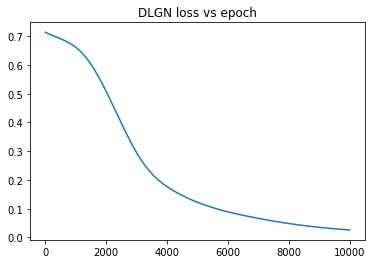

In [11]:
#@title **Load model**
if infer_model:
  # load numpy array from npz file
  from numpy import load
  # load dict of arrays
  dict_data = load(file_name_load,allow_pickle=True)
  losses=dict_data['arr_0']
  test_error=dict_data['arr_1'].item()
  train_error=dict_data['arr_2'].item()
  predictions_dlgn=dict_data['arr_3']
  DLGN_obj_final=dict_data['arr_4'].item()
  DLGN_obj_store=dict_data['arr_5']
  plt.figure()
  plt.title("DLGN loss vs epoch")
  fig=plt.plot(losses[:10000])
  if model_type == "Classification":
    print("test_error",test_error/len(test_data_curr))
    print("train_error",train_error/len(train_data_curr))
    print('DLGN acc=',np.sum(predictions_dlgn==test_labels_curr)/len(test_data_curr))
  if model_type == "Regression":
    print("test_error",test_error)
    print("train_error",train_error)

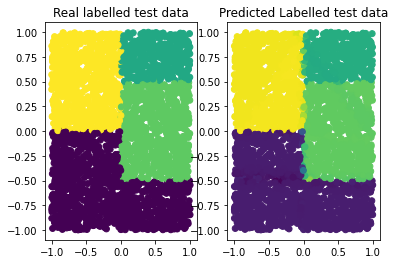

In [12]:
#@title **Data vs prediction scatter plot**
plt.figure()
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.scatter(test_data_curr[:,0], test_data_curr[:,1], c=test_labels_curr)
plt.title("Real labelled test data")

plt.subplot(1, 2, 2) # index 2
plt.scatter(test_data_curr[:,0], test_data_curr[:,1], c=predictions_dlgn)
plt.title("Predicted Labelled test data")
plt.show()

In [13]:
#@title **Calculate Path values**
if infer_model:
  def path_value_cal(DLGN_obj):
    complete_path_vals = np.zeros(tuple(num_hidden_nodes))
    complete_paths = list(cartesian_prod(*[range(x) for x in num_hidden_nodes]))
    
    for path in complete_paths:
      temp = np.dot(DLGN_obj.value_layers[0].weight.data.numpy()[path[0],:], np.ones(input_dim))
      for k in range(1,num_hidden_layers):
          temp *= DLGN_obj.value_layers[k].weight.data.numpy()[path[k], path[k-1]]
      temp *= DLGN_obj.value_layers[num_hidden_layers].weight.data.numpy()[0, path[-1]]
      complete_path_vals[path]=temp
    return complete_paths,complete_path_vals


  if print_all_paths:
    print("================================BEST EPOCH======================================")
    DLGN_obj = DLGN_obj_final
    complete_paths,complete_path_vals = path_value_cal(DLGN_obj)
    print(complete_paths)
    print(complete_path_vals)
    # print("Path values of layer {} node {}".format(layer_num,node_num))
    # print(complete_paths[node_num-1::num_hidden_nodes[layer_num-1]])
    # print(complete_path_vals[:,:,node_num-1]) #3rd layer nodes
    # print(complete_path_vals[:,node_num-1,:])#2nd layer nodes
    print("=================================0TH EPOCH====================================")

    DLGN_obj = DLGN_obj_store[0]
    complete_paths,complete_path_vals = path_value_cal(DLGN_obj)
    print(complete_paths)
    print(complete_path_vals)
    # print("Path values of layer {} node {}".format(layer_num,node_num))
    # print(complete_paths[node_num-1::num_hidden_nodes[layer_num-1]])
    # print(complete_path_vals[:,:,node_num-1]) #3rd layer nodes
    # print(complete_path_vals[:,node_num-1,:])#2nd layer nodes
    print("===============================MIDDLE EPOCH====================================")

    DLGN_obj = DLGN_obj_store[int(np.sqrt(num_epoch)//2)]
    complete_paths,complete_path_vals = path_value_cal(DLGN_obj)
    print(complete_paths)
    print(complete_path_vals)
    # print("Path values of layer {} node {}".format(layer_num,node_num))
    # print(complete_paths[node_num-1::num_hidden_nodes[layer_num-1]])
    # print(complete_path_vals[:,:,node_num-1]) #3rd layer nodes
    # print(complete_path_vals[:,node_num-1,:])#2nd layer nodes
    print("================================LAST EPOCH==================================")

    DLGN_obj = DLGN_obj_store[int(np.sqrt(num_epoch))-1]
    complete_paths,complete_path_vals = path_value_cal(DLGN_obj)
    print(complete_paths)
    print(complete_path_vals)
    # print("Path values of layer {} node {}".format(layer_num,node_num))
    # print(complete_paths[node_num-1::num_hidden_nodes[layer_num-1]])
    # print(complete_path_vals[:,:,node_num-1]) #3rd layer nodes
    # print(complete_path_vals[:,node_num-1,:])#2nd layer nodes

In [14]:
#@title **Path value of a particular path of a particular epoch**
def print_path_value(enter_path,enter_epoch):
  if infer_model:
    DLGN_obj = DLGN_obj_store[int(np.sqrt(enter_epoch))]
    complete_paths,complete_path_vals = path_value_cal(DLGN_obj)
    # print(f'Value of path {enter_path} of epoch {enter_epoch} is : {complete_path_vals[enter_path]}')
    return complete_path_vals[enter_path]

In [15]:
#@title **Visualization of node hyperplane for a particular epoch**
def show_node_hyp(enter_epoch):
  if infer_model:
    DLGN_obj = DLGN_obj_store[int(np.sqrt(enter_epoch))]
    effective_weights, effective_biases = DLGN_obj.return_gating_functions()
    X=test_data_curr[:,0]
    Y=test_data_curr[:,1]
    test_data_torch = torch.Tensor(test_data_curr)
    values,gate_scores =DLGN_obj(test_data_torch)

    if model_type == "Classification":
      test_preds = torch.cat((-1*values[-1],values[-1]),dim=1)
      predictions = torch.argmax(test_preds,dim=1).numpy()
    if model_type == "Regression":
      test_preds = values[-1]
      predictions=test_preds.detach().numpy()

    no_rows=num_hidden_layers+1
    no_colns = max_no_of_nodes
    fig,ax=plt.subplots(no_rows,no_colns,figsize=(5*no_colns,4*no_rows)) 
    fig.tight_layout(pad=2)
    fig.text(0,0,s="Epoch "+str(enter_epoch))
    for k in range(no_colns//2):
      im_hide = ax[0,k].axis('off')
    for k in range(no_colns//2+2,no_colns):
      im_hide = ax[0,k].axis('off')
    im0=ax[0,no_colns//2].scatter(X, Y, c=test_labels_curr,vmin=-1,vmax=1)
    ax[0,no_colns//2].title.set_text("Real")
    ax[0,no_colns//2].set_xlim(-2,2)
    ax[0,no_colns//2].set_ylim(-4,4)
    divider = make_axes_locatable(ax[0,no_colns//2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im0, cax=cax, orientation='vertical')
    im1=ax[0,no_colns//2+1].scatter(X, Y, c=predictions,vmin=-1,vmax=1)
    ax[0,no_colns//2+1].title.set_text("Predicted")
    ax[0,no_colns//2+1].set_xlim(-2,2)
    ax[0,no_colns//2+1].set_ylim(-4,4)
    divider = make_axes_locatable(ax[0,no_colns//2+1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    for j in range(num_hidden_layers):
      for i in range( num_hidden_nodes[j]):
        weight = effective_weights[j][i].data.numpy()
        bias = effective_biases[j][i].data.numpy()
        Z = ((test_data_curr@weight.T)+bias)>0
        line_eq = (-bias - X*weight[0])/weight[1]
        im=ax[j+1,i].scatter(X, Y, c=Z,vmin=-1,vmax=1)
        im1=ax[j+1,i].plot(X,line_eq,label="("+str(round(weight.data[0],4))+")x+"+"("+str(round(weight.data[1],4))+")y+"+"("+str(round(bias.item(),2))+")=0")
        ax[j+1,i].set_xlim(-2,2)
        ax[j+1,i].set_ylim(-4,4)
        ax[j+1,i].title.set_text("Layer: "+str(j+1)+" Node: "+str(i+1))
        ax[j+1,i].legend()
        divider = make_axes_locatable(ax[j+1,i])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
    path0="/content/drive/MyDrive/Research/DLGN_fixed_node/"
    if save_img:
      fig.savefig(str(path0)+"Epoch_"+str(enter_epoch)+".pdf", dpi=300,format="pdf")					

In [16]:
#@title **Node hyperplane for best model**
if infer_model:
  if best_epoch_show:
    effective_weights, effective_biases = DLGN_obj_final.return_gating_functions()
    X=test_data_curr[:,0]
    Y=test_data_curr[:,1]
    no_rows=num_hidden_layers+1
    no_colns = max_no_of_nodes
    fig,ax=plt.subplots(no_rows,no_colns,figsize=(5*no_colns,4*no_rows)) 
    fig.tight_layout(pad=2)
    fig.text(0,0,s="Best Epoch")
    for k in range(no_colns//2):
      im_hide = ax[0,k].axis('off')
    for k in range(no_colns//2+2,no_colns):
      im_hide = ax[0,k].axis('off')
    im0=ax[0,no_colns//2].scatter(X, Y, c=test_labels_curr,vmin=-1,vmax=1)
    ax[0,no_colns//2].title.set_text("Real")
    ax[0,no_colns//2].set_xlim(-2,2)
    ax[0,no_colns//2].set_ylim(-4,4)
    divider = make_axes_locatable(ax[0,no_colns//2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im0, cax=cax, orientation='vertical')
    im1=ax[0,no_colns//2+1].scatter(X, Y, c=predictions_dlgn,vmin=-1,vmax=1)
    ax[0,no_colns//2+1].title.set_text("Predicted")
    ax[0,no_colns//2+1].set_xlim(-2,2)
    ax[0,no_colns//2+1].set_ylim(-4,4)
    divider = make_axes_locatable(ax[0,no_colns//2+1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    for j in range(num_hidden_layers):
      for i in range( num_hidden_nodes[j]):
        weight = effective_weights[j][i].data.numpy()
        bias = effective_biases[j][i].data.numpy()
        Z = ((test_data_curr@weight.T)+bias)>0
        line_eq = (-bias - X*weight[0])/weight[1]
        im=ax[j+1,i].scatter(X, Y, c=Z,vmin=-1,vmax=1)
        im1=ax[j+1,i].plot(X,line_eq,label="("+str(round(weight.data[0],4))+")x+"+"("+str(round(weight.data[1],4))+")y+"+"("+str(round(bias.item(),2))+")=0")
        ax[j+1,i].set_xlim(-2,2)
        ax[j+1,i].set_ylim(-4,4)
        ax[j+1,i].title.set_text("Layer: "+str(j+1)+" Node: "+str(i+1))
        ax[j+1,i].legend()
        divider = make_axes_locatable(ax[j+1,i])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
    # fig.subplots_adjust(right=0.8)
    # cbar_ax = fig.add_axes([0.85, 0.12, 0.01, 0.82])
    # fig.colorbar(im0, cax=cbar_ax)
    path0="/content/drive/MyDrive/Research/DLGN_fixed_node/"
    if save_img:
      fig.savefig(str(path0)+"Best_epoch.pdf", dpi=300,format="pdf")

In [17]:
#@title **Change of node hyperplane for each layer**
def perfectCube(N) :
	cube_root = round(N**(1/3));
	if cube_root * cube_root * cube_root == N :
		return True;
	else :
		return False;
if infer_model:
	if test_on_train_data:
		test_data_curr = train_data_curr
		test_labels_curr = train_labels_curr
	
	if show_all_epoch_node_hyperplane:
		for epoch_no in range(len(DLGN_obj_store)):
			if ((epoch_no%10)==0):
				print("________________________________")
				print("=======Epoch no: ", epoch_no**2)
				print("________________________________")

				effective_weights, effective_biases = DLGN_obj_store[epoch_no].return_gating_functions()
				X=test_data_curr[:,0]
				Y=test_data_curr[:,1]
				test_data_torch = torch.Tensor(test_data_curr)
				values,gate_scores =DLGN_obj_store[epoch_no](test_data_torch)

				if model_type == "Classification":
					test_preds = torch.cat((-1*values[-1],values[-1]),dim=1)
					predictions = torch.argmax(test_preds,dim=1).numpy()
				if model_type == "Regression":
					test_preds = values[-1]
					predictions=test_preds.detach().numpy()

				no_rows=num_hidden_layers+1
				no_colns = max_no_of_nodes
				fig,ax=plt.subplots(no_rows,no_colns,figsize=(5*no_colns,4*no_rows)) 
				fig.tight_layout(pad=2)
				fig.text(0,0,s="Epoch no: "+ str(epoch_no**2))
				for k in range(no_colns//2):
					im_hide = ax[0,k].axis('off')
				for k in range(no_colns//2+2,no_colns):
					im_hide = ax[0,k].axis('off')
				im0=ax[0,no_colns//2].scatter(X, Y, c=test_labels_curr,vmin=-1,vmax=1)
				ax[0,no_colns//2].title.set_text("Real")
				ax[0,no_colns//2].set_xlim(-2,2)
				ax[0,no_colns//2].set_ylim(-4,4)
				divider = make_axes_locatable(ax[0,no_colns//2])
				cax = divider.append_axes('right', size='5%', pad=0.05)
				fig.colorbar(im0, cax=cax, orientation='vertical')

				im1=ax[0,no_colns//2+1].scatter(X, Y, c=predictions,vmin=-1,vmax=1)
				ax[0,no_colns//2+1].title.set_text("Predicted")
				ax[0,no_colns//2+1].set_xlim(-2,2)
				ax[0,no_colns//2+1].set_ylim(-4,4)
				divider = make_axes_locatable(ax[0,no_colns//2+1])
				cax = divider.append_axes('right', size='5%', pad=0.05)
				fig.colorbar(im1, cax=cax, orientation='vertical')

				for j in range(num_hidden_layers):
					for i in range( num_hidden_nodes[j]):
						weight = effective_weights[j][i].data.numpy()
						bias = effective_biases[j][i].data.numpy()
						Z = ((test_data_curr@weight.T)+bias)>0
						line_eq = (-bias - X*weight[0])/weight[1]

						im=ax[j+1,i].scatter(X, Y, c=Z,vmin=-1,vmax=1)
						im1=ax[j+1,i].plot(X,line_eq,label="("+str(round(weight.data[0],4))+")x+"+"("+str(round(weight.data[1],4))+")y+"+"("+str(round(bias.item(),4))+")=0")
						ax[j+1,i].set_xlim(-2,2)
						ax[j+1,i].set_ylim(-4,4)
						ax[j+1,i].title.set_text("Layer: "+str(j+1)+" Node: "+str(i+1))
						ax[j+1,i].legend()
						divider = make_axes_locatable(ax[j+1,i])
						cax = divider.append_axes('right', size='5%', pad=0.05)
						fig.colorbar(im, cax=cax, orientation='vertical')
				# fig.subplots_adjust(right=0.8)
				# cbar_ax = fig.add_axes([0.85, 0.12, 0.01, 0.82])
				# fig.colorbar(im0, cax=cbar_ax)
				path="/content/drive/MyDrive/Research/DLGN_fixed_node/Layer_3_Node_2/"
				if save_img:
					fig.savefig(str(path)+"Epoch_"+str(epoch_no**2)+"_.png", dpi=300)
				plt.show


In [18]:
#@title **Visualization of a particular path for a particular epoch**
def show_path_hyp(enter_path,enter_epoch):
  if infer_model:
    DLGN_obj = DLGN_obj_store[int(np.sqrt(enter_epoch))]
    effective_weights, effective_biases = DLGN_obj.return_gating_functions()
    X=test_data_curr[:,0]
    Y=test_data_curr[:,1]
    fig,ax=plt.subplots(1,2,figsize=(5*2,4)) 
    fig.tight_layout(pad=2)
    fig.text(0,0,s="Epoch "+str(enter_epoch))
    im0=ax[0].scatter(X, Y, c=test_labels_curr,vmin=-1,vmax=1)
    ax[0].title.set_text("Real Data")
    ax[0].set_xlim(-2,2)
    ax[0].set_ylim(-4,4)
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im0, cax=cax, orientation='vertical')
    Z_path = []
    for j in range(len(enter_path)):
      weight = effective_weights[j][enter_path[j]].data.numpy()
      bias = effective_biases[j][enter_path[j]].data.numpy()
      Z = ((test_data_curr@weight.T)+bias)>0
      Z_path.append(Z)
    Z_result = Z_path[0]
    for i in range(1,len(Z_path)):
      Z_result = Z_result & Z_path[i]

    data_frac_by_path = np.count_nonzero(Z_result)/len(test_labels_curr)*100 #Stregth of the path defined as fraction of data points active by that path
    Z_res_path=Z_result*test_labels_curr
    Z_res_non_zero = Z_res_path[np.nonzero(Z_res_path)]
    path_std=np.std(Z_res_non_zero)##Path purity defined as the path variance i.e., variance of the data points active for that path
    path_mean=np.mean(Z_res_non_zero)

    im1=ax[1].scatter(X, Y, c=Z_result,vmin=-1,vmax=1)
    ax[1].text(0.5,.9,"data_frac_by_path: "+str(round(data_frac_by_path,2)),horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)
    ax[1].text(0.5,0.1,"Path_mean: "+str(round(path_mean,2))+" ,std: "+str(round(path_std,2)),horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)

    ax[1].title.set_text(str(enter_path)+" Path visualization")
    ax[1].set_xlim(-2,2)
    ax[1].set_ylim(-4,4)
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im0, cax=cax, orientation='vertical')
    path0="/content/drive/MyDrive/Research/DLGN_fixed_node/"
    if save_img:
      fig.savefig(str(path0)+"Path_viz_Epoch_"+str(enter_epoch)+".pdf", dpi=300,format="pdf")


def return_path_hyp(enter_path,enter_epoch):
  if infer_model:
    DLGN_obj = DLGN_obj_store[int(np.sqrt(enter_epoch))]
    effective_weights, effective_biases = DLGN_obj.return_gating_functions()
    X=test_data_curr[:,0]
    Y=test_data_curr[:,1]
    
    Z_path = []
    for j in range(len(enter_path)):
      weight = effective_weights[j][enter_path[j]].data.numpy()
      bias = effective_biases[j][enter_path[j]].data.numpy()
      Z = ((test_data_curr@weight.T)+bias)>0
      Z_path.append(Z)
    Z_result = Z_path[0]
    for i in range(1,len(Z_path)):
      Z_result = Z_result & Z_path[i]
    data_frac_by_path = np.count_nonzero(Z_result)/len(test_labels_curr)*100 #Stregth of the path defined as fraction of data points active by that path
    Z_res_path=Z_result*test_labels_curr
    Z_res_non_zero = Z_res_path[np.nonzero(Z_res_path)]
    path_std=np.std(Z_res_non_zero)##Path purity defined as the path variance i.e., variance of the data points active for that path
    path_mean=np.mean(Z_res_non_zero)
    return Z_result,round(data_frac_by_path,2),round(path_mean,2),round(path_std,2)

In [ ]:
#@title **Change of W_&_B for all node**
if infer_model:
  # layer_num = 3
  # node_num = 2
  no_rows=num_hidden_layers
  no_colns = max_no_of_nodes
  fig,ax=plt.subplots(no_rows,no_colns,figsize=(5*no_colns,4*no_rows)) 
  fig.tight_layout(pad=2)
  fig.text(0,0,s="Change of weights")
  for layer_num in range(num_hidden_layers):
    for node_num in range(num_hidden_nodes[layer_num]):
      weight_0 = []
      weight_1 = []
      bias = []
      epoch_count=range(len(DLGN_obj_store))
      for epoch_no in range(len(DLGN_obj_store)):
        effective_weights, effective_biases = DLGN_obj_store[epoch_no].return_gating_functions()
        weight_0.append(effective_weights[layer_num][node_num].data.numpy()[0])
        weight_1.append(effective_weights[layer_num][node_num].data.numpy()[1])
        bias.append(effective_biases[layer_num][node_num].data.numpy())
      im1=ax[layer_num,node_num].plot(epoch_count,weight_0,label="Weight_0")
      im2=ax[layer_num,node_num].plot(epoch_count,weight_1,label="Weight_1")
      im3=ax[layer_num,node_num].plot(epoch_count,bias,label="bias")
      ax[layer_num,node_num].title.set_text("Layer: "+str(layer_num+1)+" Node: "+str(node_num+1))
      ax[layer_num,node_num].legend()

In [20]:
def plot_path_value_variation(enter_path,plot_epoch): #plot_epoch is till which epoch want to plot
  path_value=[]
  path_epoch_count = []
  for i in range(plot_epoch):
    if(perfectSq(i)):
      path_epoch_count.append(i)
      path_value.append(print_path_value(enter_path,i))
  plt.plot(path_epoch_count,path_value)

**Sanity check of path decomposition**

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


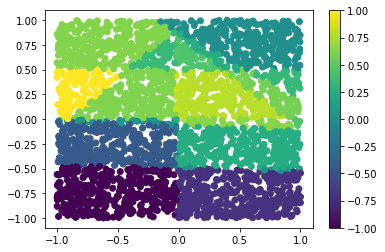

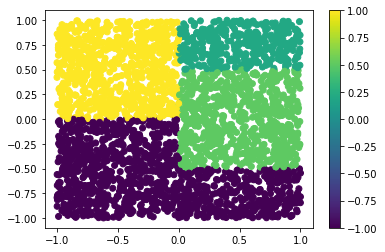

In [21]:
if infer_model:
  X=test_data_curr[:,0]
  Y=test_data_curr[:,1]
  Z=np.zeros(X.shape)
  enter_epoch = 5000
  for i in range(max_no_of_nodes):
    for j in range(max_no_of_nodes):
      for k in range(max_no_of_nodes):
        enter_path=(i,j,k)
        val=print_path_value(enter_path,enter_epoch)
        Z_result,data_frac_by_path,path_mean,path_std=return_path_hyp(enter_path,enter_epoch)
        Z+=val*Z_result
  plt.scatter(X,Y,c=Z,vmin=-1,vmax=1)
  plt.colorbar()
  plt.figure()
  plt.scatter(X,Y,c=test_labels_curr,vmin=-1,vmax=1)
  plt.colorbar()

**Array of dict storing path,path_val,data frac,mean,std**

In [22]:
plot_epoch = 5000
path_val_store = []
for i in range(max_no_of_nodes):
  for j in range(max_no_of_nodes):
    for k in range(max_no_of_nodes):
      enter_path=(i,j,k)
      path_value=[]
      path_epoch_count = []
      for pe in range(plot_epoch):
        if(perfectSq(pe)):
          path_epoch_count.append(pe)
          path_value.append(round(print_path_value(enter_path,pe),3))
      Z_result,data_frac_by_path,path_mean,path_std=return_path_hyp(enter_path,5000)
      Dict = {}
      Dict['val']=(path_epoch_count,path_value)
      Dict['path']=enter_path
      Dict['data_frac_by_path']=data_frac_by_path
      Dict['path_mean']=path_mean
      Dict['path_std']=path_std
      path_val_store.append(Dict)

In [23]:
path_val_store
from operator import itemgetter
newlist = sorted(path_val_store, key=itemgetter('path')) 

**Printing vals for one path**

In [24]:
find_path = (1,2,3)
newlist[find_path[0]*max_no_of_nodes**2+find_path[1]*max_no_of_nodes+find_path[2]]

{'val': ([0,
   1,
   4,
   9,
   16,
   25,
   36,
   49,
   64,
   81,
   100,
   121,
   144,
   169,
   196,
   225,
   256,
   289,
   324,
   361,
   400,
   441,
   484,
   529,
   576,
   625,
   676,
   729,
   784,
   841,
   900,
   961,
   1024,
   1089,
   1156,
   1225,
   1296,
   1369,
   1444,
   1521,
   1600,
   1681,
   1764,
   1849,
   1936,
   2025,
   2116,
   2209,
   2304,
   2401,
   2500,
   2601,
   2704,
   2809,
   2916,
   3025,
   3136,
   3249,
   3364,
   3481,
   3600,
   3721,
   3844,
   3969,
   4096,
   4225,
   4356,
   4489,
   4624,
   4761,
   4900],
  [-0.008,
   -0.008,
   -0.008,
   -0.008,
   -0.008,
   -0.008,
   -0.008,
   -0.008,
   -0.008,
   -0.008,
   -0.008,
   -0.008,
   -0.009,
   -0.009,
   -0.009,
   -0.009,
   -0.009,
   -0.01,
   -0.01,
   -0.01,
   -0.011,
   -0.011,
   -0.011,
   -0.012,
   -0.012,
   -0.013,
   -0.013,
   -0.014,
   -0.015,
   -0.015,
   -0.016,
   -0.017,
   -0.018,
   -0.019,
   -0.021,
   -0.022,
   -0.

**5x25 path vals**

<ipython-input-25-0f19c9841784>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5,5))


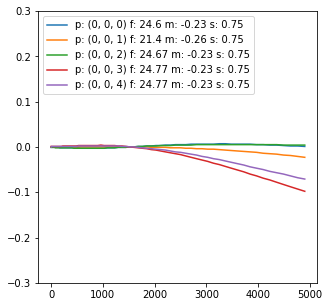

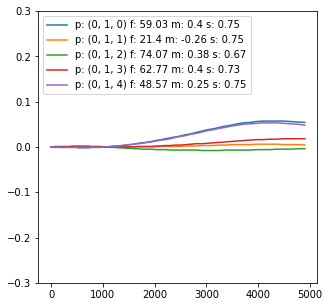

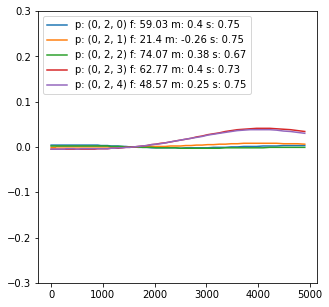

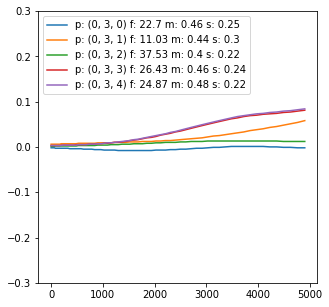

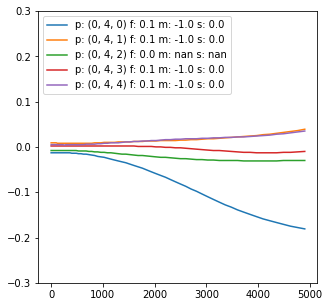

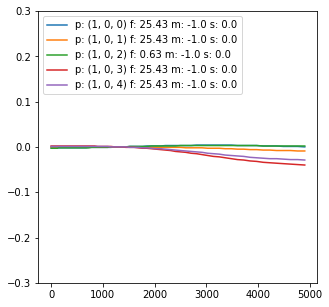

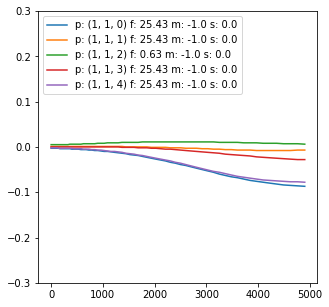

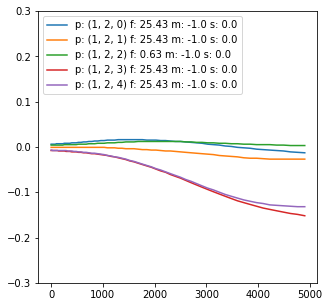

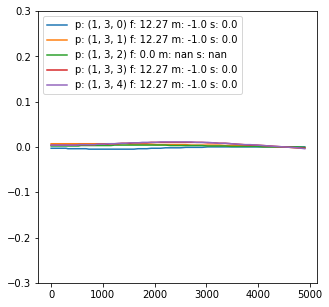

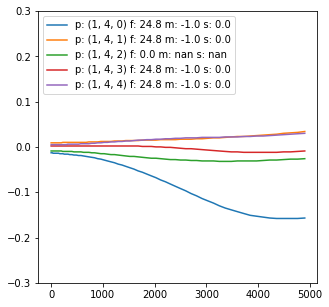

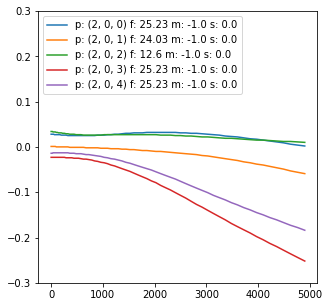

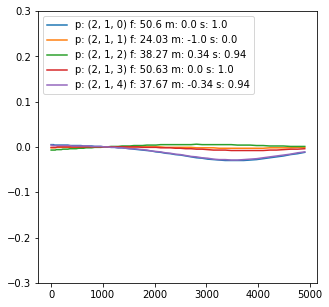

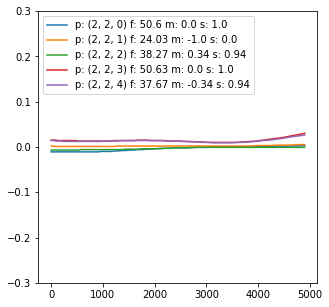

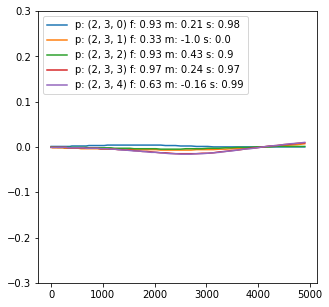

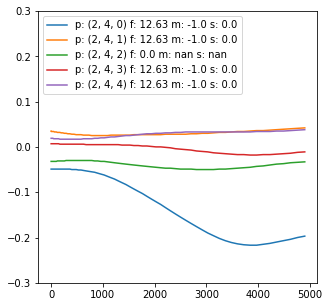

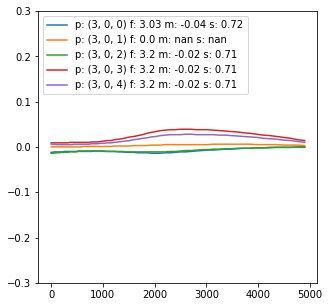

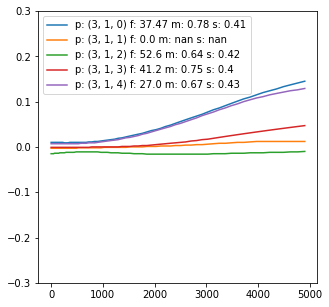

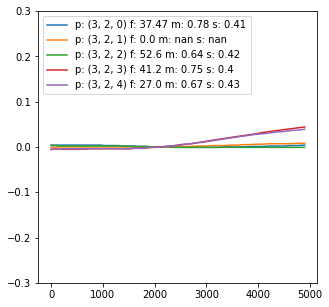

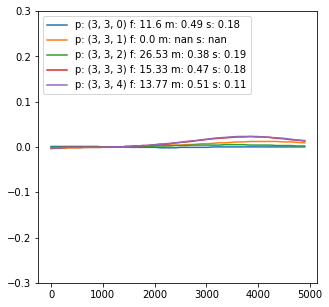

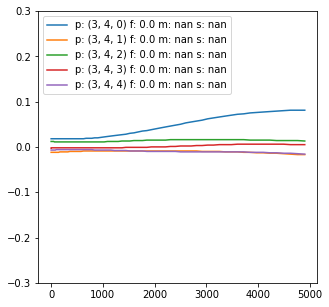

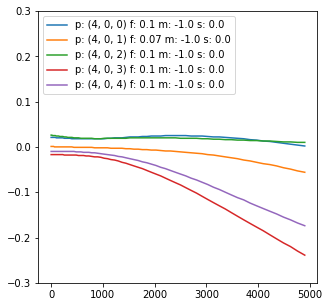

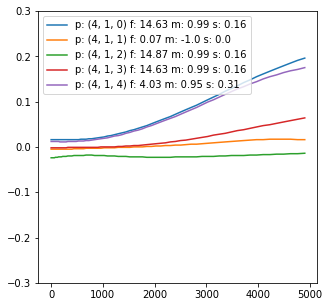

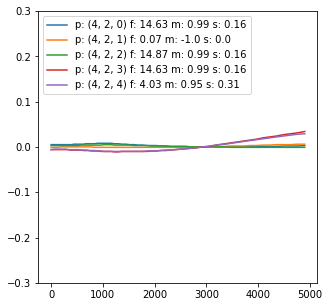

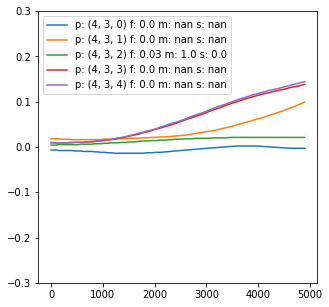

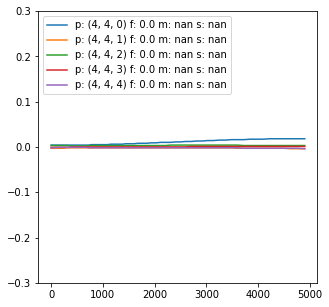

In [25]:
for index in range(max_no_of_nodes**num_hidden_layers):
  if(index%5==0):
    plt.figure(figsize=(5,5))
  plt.plot(newlist[index]['val'][0],newlist[index]['val'][1],label="p: "+str(newlist[index]['path'])+" f: "+str(newlist[index]['data_frac_by_path'])+" m: "+str(newlist[index]['path_mean'])+" s: "+str(newlist[index]['path_std']))
  plt.legend(loc="upper left")
  plt.ylim(-.3, .3)

**Path visualization of one path**

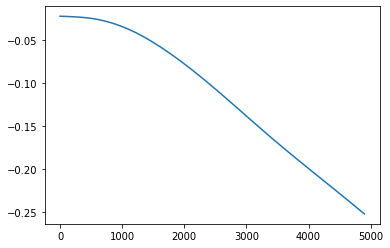

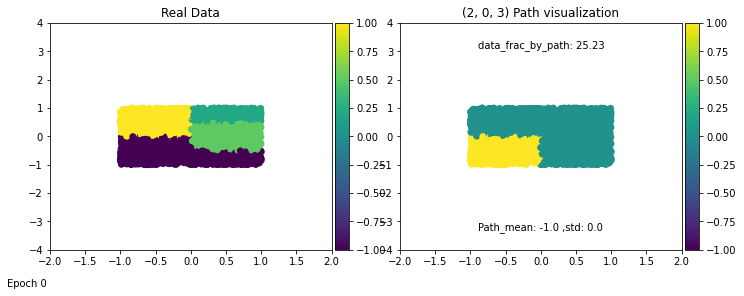

In [26]:
if infer_model: #if we have similar kind of paths only one of them vary much rest don't vary that much (2,1/2,0/3) (1,4,0/1/3/4) #seed 365
  enter_path = (2,0,3)#(2,2,3)#(2,1,0)#(2,1,3)#(1,4,0)#(1,4,3)#(1,4,1)#(1,4,4) #(2,0,3) #(2,2,0)  
  plot_epoch = 5000
  enter_epoch = 0
  plot_path_value_variation(enter_path,plot_epoch)
  show_path_hyp(enter_path,enter_epoch)

**All node visualization**

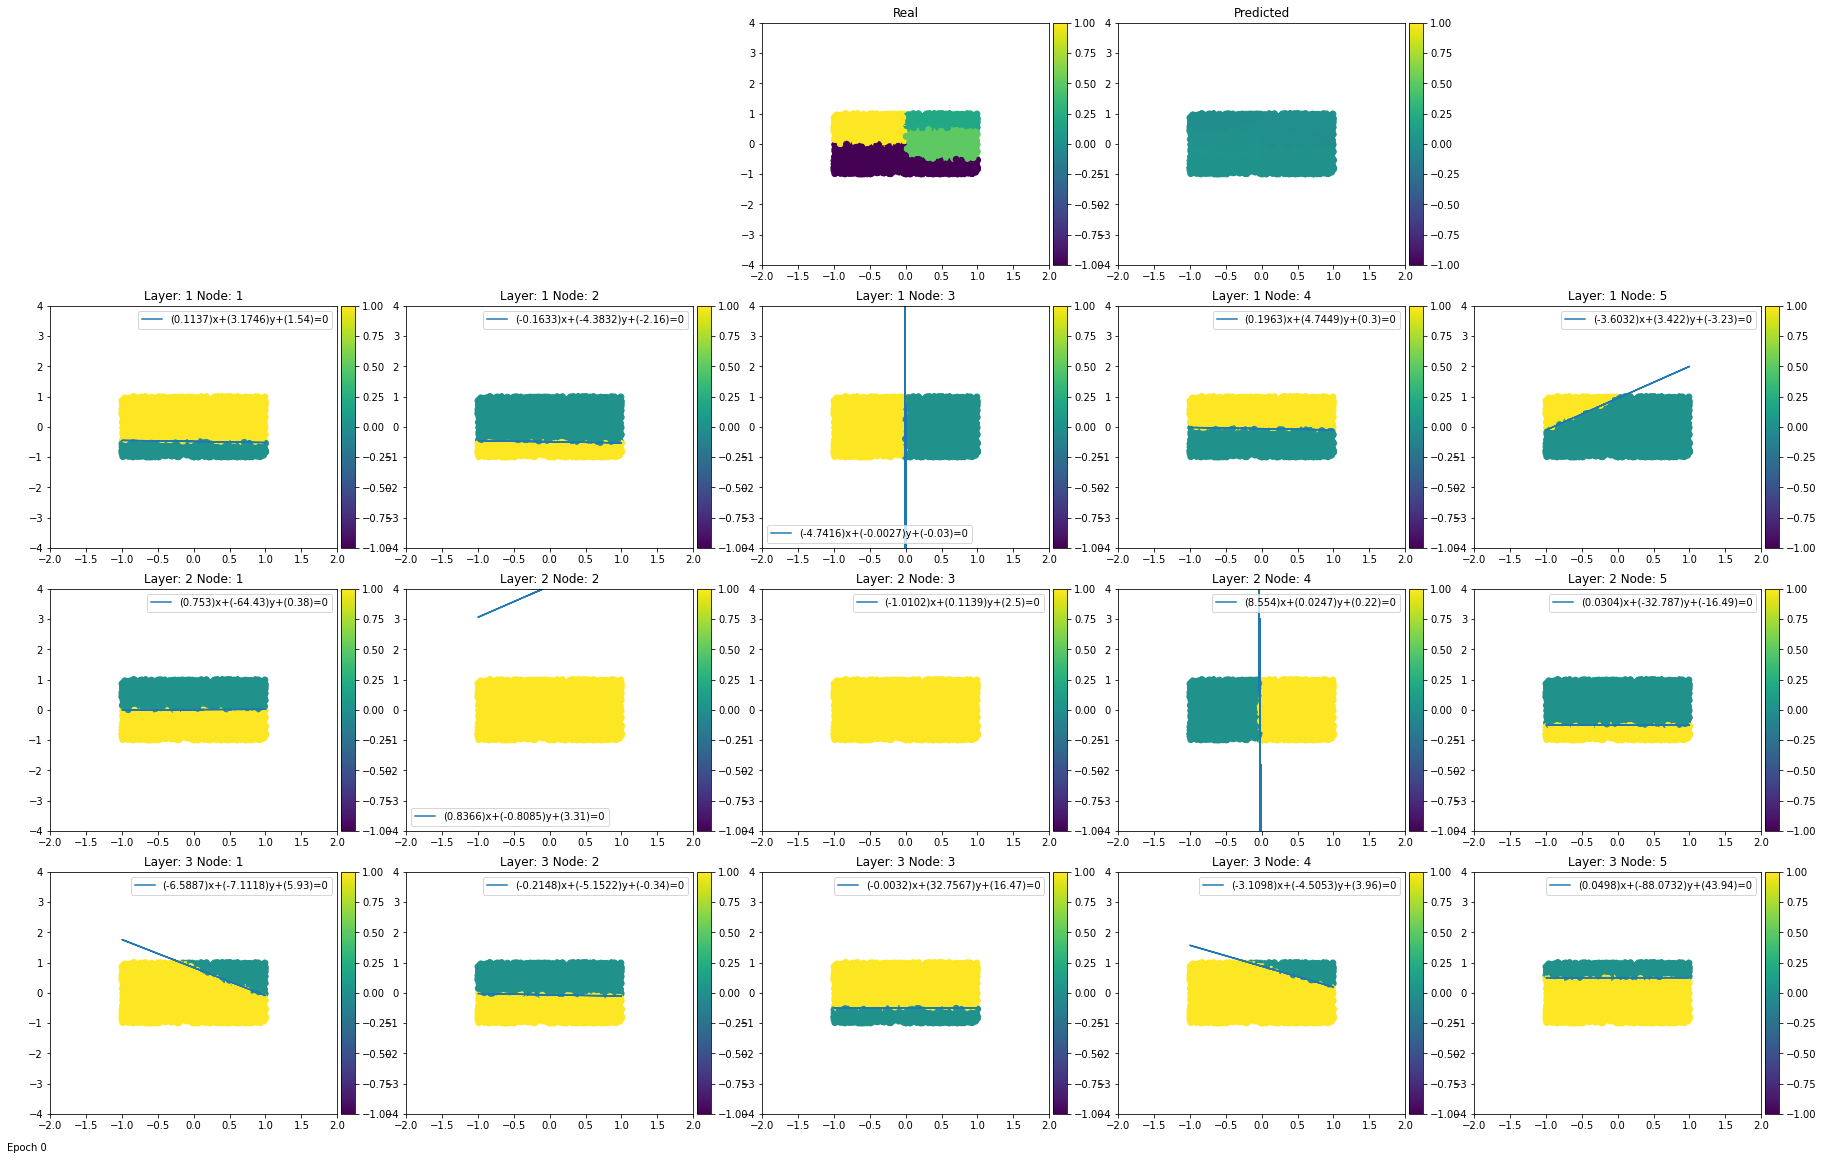

In [27]:
if infer_model:
  show_node_hyp(enter_epoch)

In [28]:
#@title **Rough not needed**

# epoch=len(DLGN_obj_store)
# value = np.zeros((epoch,num_hidden_layers,max_no_of_nodes))

# for index,model in enumerate(DLGN_obj_store):
#   for i in range(len(model.gating_layers)-1):
#     for j in range(len(model.gating_layers[i].weight)):
#       value[index][i][j]=model.gating_layers[i].weight[j].data.detach().numpy().mean(axis=0)
# epoch_count=range(epoch)
# plt.figure(figsize=(10, 5))
# for i in range(value[0].shape[0]):
#   for j in range(value[0].shape[1]):
#     plt.plot(epoch_count,value[:,i,j],label=str(i+1)+"_"+str(j+1))
#     plt.legend()
# DLGN_obj_store[0]
# DLGN_obj_store[0](torch.Tensor([1.,0.0]))
# for j in range(4):
#   print(DLGN_obj_store[0].value_layers[j].weight)
# DLGN_obj_store[-1](torch.Tensor([0,1]))
# n = 100000
# x0x1_min = [-1.0, -1.0]
# x0x1_max = [1.0, 1.0]
# data = np.random.uniform(low=x0x1_min, high=x0x1_max, size=(n,2))
# y=[]
# for i,val in enumerate(data):
#   if(-1<=val[0]<=0 and 0<=val[1]<=1):
#     y.append(1)
#   elif (0<=val[0]<=1 and 0.5<=val[1]<=1):
#     y.append(0.2)
#   elif(0<=val[0]<=1 and -0.5<=val[1]<=0.5):
#     y.append(0.5)
#   else:
#     y.append(-1)
#   # elif (val[0] in [-1,0] and val[1] in [0,1]) or (val[0] in [0,1] and val[1] in [-0.5,-1]):
# fig=plt.scatter(data[:,0], data[:,1],c=y,s=10)
# # print(data)
# def path_value_cal(DLGN_obj):
#   complete_path_vals = np.zeros(tuple(num_hidden_nodes))
#   # partial_path_vals_list=[]
#   # for j in range(num_hidden_layers):
#   #     partial_path_vals_list.append(np.zeros(tuple(num_hidden_nodes[j:])))

      

#   complete_paths = list(cartesian_prod(*[range(x) for x in num_hidden_nodes]))
#   # partial_paths_list=[]

#   # for j in range(num_hidden_layers):
#   #     partial_paths_list.append(list(cartesian_prod(*[list(range(x)) for x in num_hidden_nodes[j:]])))

      
#   for path in complete_paths:
#       temp = np.dot(DLGN_obj.value_layers[0].weight.data.numpy()[path[0],:], np.ones(input_dim))
#       for k in range(1,num_hidden_layers):
#           temp *= DLGN_obj.value_layers[k].weight.data.numpy()[path[k], path[k-1]]
#       temp *= DLGN_obj.value_layers[num_hidden_layers].weight.data.numpy()[0, path[-1]]
#       complete_path_vals[path]=temp
          

  # for j in range(num_hidden_layers):
  #     for path in partial_paths_list[j]:
  #         temp = DLGN_obj.value_layers[j].bias.data.numpy()[path[0]]
  #         for k in range(j+1,num_hidden_layers):
  # #             temp *= DLGN_obj.value_layers[k].weight.data.numpy()[path[k], path[k-1]]
  #             temp *= DLGN_obj.value_layers[k].weight.data.numpy()[path[k-j], path[k-1-j]]            
  #         temp *= DLGN_obj.value_layers[num_hidden_layers].weight.data.numpy()[0, path[-1]]        
  #         partial_path_vals_list[j][path]=temp
  # return complete_paths,complete_path_vals
#return partial_paths_list,partial_path_vals_list,complete_paths,complete_path_vals
